Initial dataset tsne and cosine plots using Biobert embed

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating embeddings for questions and outputs...


100%|██████████| 1500/1500 [28:29<00:00,  1.14s/it]


Calculating similarity and distance scores...
Generating t-SNE plot...


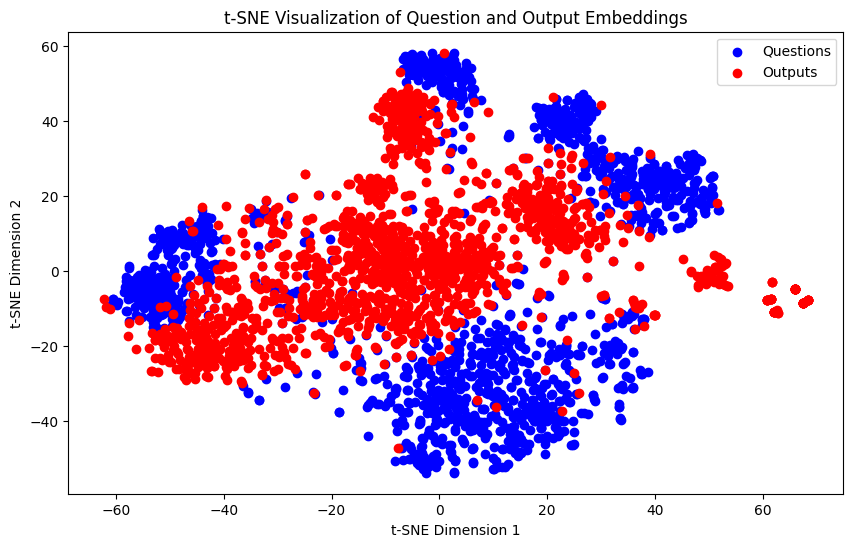

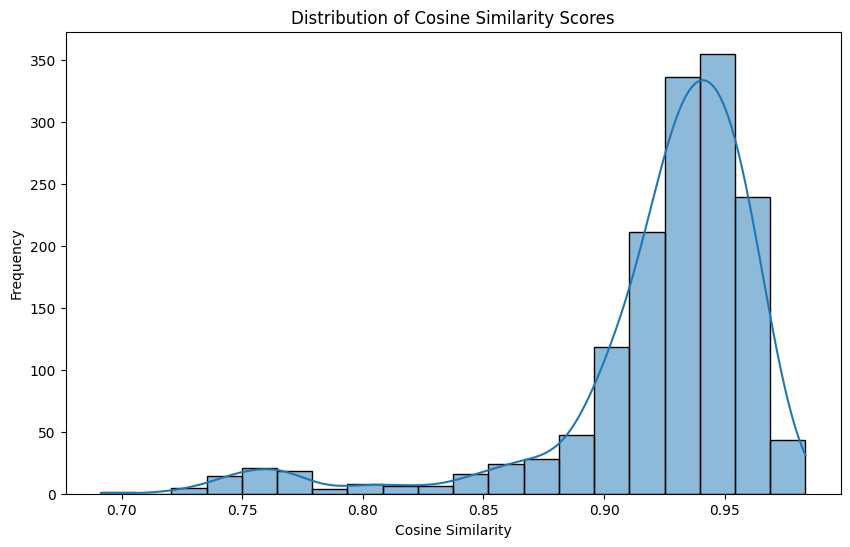

Sample question embeddings (first 3): tensor([[ 1.4751e-01, -1.3439e-01,  1.7445e-04,  ...,  2.7531e-01,
          1.2860e-03, -1.3915e-01],
        [ 5.7989e-02, -1.4611e-01, -3.3140e-02,  ...,  2.4635e-01,
          1.3440e-01,  1.5149e-02],
        [ 3.1417e-02, -2.7978e-01, -2.5014e-02,  ...,  2.9446e-01,
          1.7036e-02, -6.6409e-02],
        [ 1.0146e-01,  1.0045e-01, -1.1553e-01,  ...,  2.8844e-01,
         -5.1504e-03, -1.3985e-01],
        [ 1.4991e-01, -1.7408e-01, -1.6520e-01,  ...,  2.7410e-01,
          1.1961e-01,  1.4321e-01]])
Sample output embeddings (first 3): tensor([[ 0.0196, -0.1424, -0.0866,  ...,  0.2093,  0.0487,  0.0311],
        [-0.0942, -0.0174, -0.0587,  ...,  0.1626,  0.1736, -0.1015],
        [-0.1229, -0.3034, -0.0381,  ...,  0.2944,  0.0867, -0.0694],
        [-0.1245,  0.1880, -0.1585,  ...,  0.2325, -0.0210, -0.0188],
        [ 0.2255, -0.2191,  0.0822,  ...,  0.2738,  0.0792,  0.1543]])
Scores saved to 'similarity_distance_scores_1500.csv'


In [7]:
# Install necessary packages in Google Colab
!pip install datasets transformers torch scikit-learn matplotlib seaborn umap-learn

# Import necessary libraries
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap

# Step 1: Load the dataset and preprocess it
dataset = load_dataset("QIAIUNCC/EYE-QA-PLUS", split="test")
df = dataset.to_pandas()

# Limit to the first 100 rows
df = df.head(1000)

# Drop 'source' and 'instruction' columns; use 'input' as 'question'
df = df.drop(columns=['source', 'instruction'])
df = df.rename(columns={'input': 'question'})
df = df[['question', 'output']]

# Step 2: Load BioBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Function to get embeddings with truncation to avoid length-related errors
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings.cpu().numpy()

# Step 3: Generate embeddings for each 'question' and 'output'
questions_embeddings = []
outputs_embeddings = []

print("Generating embeddings for questions and outputs...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    question_embedding = get_embeddings(row['question'])
    output_embedding = get_embeddings(row['output'])

    questions_embeddings.append(question_embedding)
    outputs_embeddings.append(output_embedding)

questions_embeddings = torch.cat([torch.tensor(embed) for embed in questions_embeddings])
outputs_embeddings = torch.cat([torch.tensor(embed) for embed in outputs_embeddings])

# Step 4: Calculate similarity and distance scores
print("Calculating similarity and distance scores...")

# Cosine similarity between each question and its respective output
q_to_output_cos_sim = [cosine_similarity([q], [o])[0][0] for q, o in zip(questions_embeddings, outputs_embeddings)]

# Euclidean and Manhattan distances between each question and output
q_to_output_euc_dist = [euclidean_distances([q], [o])[0][0] for q, o in zip(questions_embeddings, outputs_embeddings)]
q_to_output_man_dist = [manhattan_distances([q], [o])[0][0] for q, o in zip(questions_embeddings, outputs_embeddings)]

# Step 5: Visualizations

# 1. t-SNE visualization of question and output embeddings
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(torch.cat([questions_embeddings, outputs_embeddings]))

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:len(questions_embeddings), 0], embeddings_2d[:len(questions_embeddings), 1], c='blue', label='Questions')
plt.scatter(embeddings_2d[len(questions_embeddings):, 0], embeddings_2d[len(questions_embeddings):, 1], c='red', label='Outputs')
plt.legend()
plt.title("t-SNE Visualization of Question and Output Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# 2. Histogram of Cosine Similarity Scores
plt.figure(figsize=(10, 6))
sns.histplot(q_to_output_cos_sim, bins=20, kde=True)
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

# 3. Display few sample embeddings
print("Sample question embeddings (first 3):", questions_embeddings[:5])
print("Sample output embeddings (first 3):", outputs_embeddings[:5])

# Step 6: Save results to DataFrame and CSV
# Create DataFrame to store similarity and distance scores
results_df = pd.DataFrame({
    "Question": df['question'],
    "Output": df['output'],
    "Cosine_Similarity": q_to_output_cos_sim,
    "Euclidean_Distance": q_to_output_euc_dist,
    "Manhattan_Distance": q_to_output_man_dist
})

# Save to CSV
results_df.to_csv("similarity_distance_scores_1500.csv", index=False)
print("Scores saved to 'similarity_distance_scores_1500.csv'")


In [1]:
!pip install transformers


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Generating the new answers by passing the questions to the Finetuned Bart Model ( QA Model )
Link of the Finetuned BART Model : [https://huggingface.co/keshish/bart-eye-qa-v2](https://huggingface.co/keshish/bart-eye-qa-v2)

In [8]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import time

# Load the tokenizer and model from the Hugging Face Hub
model_name = "keshish/bart-eye-qa-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Load the dataset from Hugging Face and select the 'input' column from the test split
dataset_name = "QIAIUNCC/EYE-QA-PLUS"
dataset = load_dataset(dataset_name, split="test")
questions = dataset["input"][:1000]  # Take the first 1000 rows of the "input" column

# List to store results
generated_answers = []

# Initialize timing
start_time = time.time()

# Generate answers for each question with progress updates
for i, question in enumerate(questions, start=1):
    # Encode the input question and generate the model's answer
    inputs = tokenizer.encode(question, return_tensors="pt", truncation=True)
    outputs = model.generate(inputs, max_length=512)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Append the question and generated answer to the list
    generated_answers.append({
        "Question": question,
        "Generated Answer": answer
    })

    # Calculate elapsed time and estimated time remaining
    elapsed_time = time.time() - start_time
    avg_time_per_question = elapsed_time / i
    estimated_total_time = avg_time_per_question * len(questions)
    time_remaining = estimated_total_time - elapsed_time

    # Print progress update
    print(f"Processed question {i}/{len(questions)}")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    print(f"Estimated time remaining: {time_remaining:.2f} seconds")
    print(f"Generated Answer: {answer}")
    print("-" * 40)

# Convert results to a DataFrame and save to a new CSV file
output_csv_path = "/content/sample_data/generated_answers.csv"  # Replace with the desired output path
output_df = pd.DataFrame(generated_answers)
output_df.to_csv(output_csv_path, index=False)
print(f"\nGenerated answers saved to '{output_csv_path}'")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Streaming output truncated to the last 5000 lines.
Elapsed time: 985.98 seconds
Estimated time remaining: 6540.61 seconds
Generated Answer:  Ans. is 'a' i.e., ERG abnormalities

OPTION B IS CORRECT.
----------------------------------------
Processed question 132/1000
Elapsed time: 987.84 seconds
Estimated time remaining: 6495.81 seconds
Generated Answer:  Ans. is 'a' i.e., Ocular Trauma

OPTION B IS CORRECT.
----------------------------------------
Processed question 133/1000
Elapsed time: 999.93 seconds
Estimated time remaining: 6518.36 seconds
Generated Answer: Drug delivery systems can be utilized for the treatment of Age-Related Macular Degeneration (AMD). These systems aim to deliver drugs directly to the macula, which is the central part of the retina responsible for vision. One of the main advantages of drug delivery systems is their ability to deliver drug-delivered drugs directly into the eye. This allows for the delivery of drugs directly from the macular area to the retina, 

BioBERT : Generating Embeddings and Cosine Similarity generation for initial , newly generated answers with questions


In [13]:
# Install necessary packages in Google Colab
!pip install datasets transformers torch scikit-learn matplotlib seaborn umap-learn

# Import necessary libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from tqdm import tqdm

# Step 1: Load the custom CSV file
file_path = "/content/generated_answers.csv"  # Replace with your CSV file path
df = pd.read_csv(file_path)

# Ensure the necessary columns are present in the CSV file
assert set(['Question', 'Initial', 'Generated Answer']).issubset(df.columns), "CSV file must contain 'Question', 'Initial', and 'Generated Answer' columns."

# Step 2: Load BioBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Function to get embeddings with truncation to avoid length-related errors
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings.cpu().numpy()

# Step 3: Generate embeddings for each 'Question', 'Initial', and 'Generated Answer'
question_embeddings = []
initial_embeddings = []
generated_answer_embeddings = []

print("Generating embeddings for Question, Initial, and Generated Answer...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    question_embedding = get_embeddings(row['Question'])
    initial_embedding = get_embeddings(row['Initial'])
    generated_answer_embedding = get_embeddings(row['Generated Answer'])

    question_embeddings.append(question_embedding)
    initial_embeddings.append(initial_embedding)
    generated_answer_embeddings.append(generated_answer_embedding)

question_embeddings = torch.cat([torch.tensor(embed) for embed in question_embeddings])
initial_embeddings = torch.cat([torch.tensor(embed) for embed in initial_embeddings])
generated_answer_embeddings = torch.cat([torch.tensor(embed) for embed in generated_answer_embeddings])

# Step 4: Calculate similarity and distance scores
print("Calculating similarity and distance scores...")

# Cosine similarity between 'Initial' and 'Generated Answer'
initial_gen_cos_sim = [cosine_similarity([i], [g])[0][0] for i, g in zip(initial_embeddings, generated_answer_embeddings)]

# Cosine similarity between 'Question' and 'Generated Answer'
question_gen_cos_sim = [cosine_similarity([q], [g])[0][0] for q, g in zip(question_embeddings, generated_answer_embeddings)]

# Euclidean and Manhattan distances between 'Initial' and 'Generated Answer'
initial_gen_euc_dist = [euclidean_distances([i], [g])[0][0] for i, g in zip(initial_embeddings, generated_answer_embeddings)]
initial_gen_man_dist = [manhattan_distances([i], [g])[0][0] for i, g in zip(initial_embeddings, generated_answer_embeddings)]

# Euclidean and Manhattan distances between 'Question' and 'Generated Answer'
question_gen_euc_dist = [euclidean_distances([q], [g])[0][0] for q, g in zip(question_embeddings, generated_answer_embeddings)]
question_gen_man_dist = [manhattan_distances([q], [g])[0][0] for q, g in zip(question_embeddings, generated_answer_embeddings)]

# Calculate overall average scores for cosine similarity, Euclidean, and Manhattan distances
avg_initial_gen_cos_sim = sum(initial_gen_cos_sim) / len(initial_gen_cos_sim)
avg_question_gen_cos_sim = sum(question_gen_cos_sim) / len(question_gen_cos_sim)

avg_initial_gen_euc_dist = sum(initial_gen_euc_dist) / len(initial_gen_euc_dist)
avg_question_gen_euc_dist = sum(question_gen_euc_dist) / len(question_gen_euc_dist)

avg_initial_gen_man_dist = sum(initial_gen_man_dist) / len(initial_gen_man_dist)
avg_question_gen_man_dist = sum(question_gen_man_dist) / len(question_gen_man_dist)

# Step 5: Save results to DataFrame and CSV
# Add similarity and distance scores to the original DataFrame
df['Cosine_Similarity_Initial_Generated'] = initial_gen_cos_sim
df['Cosine_Similarity_Question_Generated'] = question_gen_cos_sim
df['Euclidean_Distance_Initial_Generated'] = initial_gen_euc_dist
df['Euclidean_Distance_Question_Generated'] = question_gen_euc_dist
df['Manhattan_Distance_Initial_Generated'] = initial_gen_man_dist
df['Manhattan_Distance_Question_Generated'] = question_gen_man_dist

# Save to a new CSV file
output_file_path = "similarity_distance_scores_output.csv"
df.to_csv(output_file_path, index=False)
print(f"Scores saved to '{output_file_path}'")

# Step 6: Print the overall average similarity and distance scores
print("Overall average cosine similarity between Initial and Generated Answer:", avg_initial_gen_cos_sim)
print("Overall average cosine similarity between Question and Generated Answer:", avg_question_gen_cos_sim)

print("Overall average Euclidean distance between Initial and Generated Answer:", avg_initial_gen_euc_dist)
print("Overall average Euclidean distance between Question and Generated Answer:", avg_question_gen_euc_dist)

print("Overall average Manhattan distance between Initial and Generated Answer:", avg_initial_gen_man_dist)
print("Overall average Manhattan distance between Question and Generated Answer:", avg_question_gen_man_dist)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating embeddings for Question, Initial, and Generated Answer...


100%|██████████| 1000/1000 [23:26<00:00,  1.41s/it]


Calculating similarity and distance scores...
Scores saved to 'similarity_distance_scores_output.csv'
Overall average cosine similarity between Initial and Generated Answer: 0.9370405098199844
Overall average cosine similarity between Question and Generated Answer: 0.908356391787529
Overall average Euclidean distance between Initial and Generated Answer: 3.4703431522810515
Overall average Euclidean distance between Question and Generated Answer: 4.370629085838795
Overall average Manhattan distance between Initial and Generated Answer: 76.29245510666182
Overall average Manhattan distance between Question and Generated Answer: 95.70385496363345


WordtoVec : Generating Embeddings and Cosine Similarity generation for initial , newly generated answers with questions

In [14]:
# Install necessary packages in Google Colab
!pip install datasets transformers torch scikit-learn matplotlib seaborn umap-learn gensim

# Import necessary libraries
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from tqdm import tqdm
import gensim.downloader as api

# Step 1: Load the custom CSV file
file_path = "/content/generated_answers.csv"  # Replace with your CSV file path
df = pd.read_csv(file_path)

# Ensure the necessary columns are present in the CSV file
assert set(['Question', 'Initial', 'Generated Answer']).issubset(df.columns), "CSV file must contain 'Question', 'Initial', and 'Generated Answer' columns."

# Step 2: Load Word2Vec model
# Download and load the pre-trained Word2Vec model
model = api.load("word2vec-google-news-300")  # Example: Google News Word2Vec model

# Function to get embeddings using Word2Vec
def get_embeddings(text):
    words = text.split()  # Split text into words
    embeddings = []
    for word in words:
        if word in model.key_to_index:  # Check if the word exists in the Word2Vec model vocabulary
            embeddings.append(model[word])
    if embeddings:
        return torch.tensor(embeddings).mean(dim=0).numpy()  # Mean of word vectors for the text
    else:
        return torch.zeros(300)  # If no words are found in the model, return a zero vector

# Step 3: Generate embeddings for each 'Question', 'Initial', and 'Generated Answer'
question_embeddings = []
initial_embeddings = []
generated_answer_embeddings = []

print("Generating embeddings for Question, Initial, and Generated Answer...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    question_embedding = get_embeddings(row['Question'])
    initial_embedding = get_embeddings(row['Initial'])
    generated_answer_embedding = get_embeddings(row['Generated Answer'])

    question_embeddings.append(question_embedding)
    initial_embeddings.append(initial_embedding)
    generated_answer_embeddings.append(generated_answer_embedding)

question_embeddings = torch.stack([torch.tensor(embed) for embed in question_embeddings])
initial_embeddings = torch.stack([torch.tensor(embed) for embed in initial_embeddings])
generated_answer_embeddings = torch.stack([torch.tensor(embed) for embed in generated_answer_embeddings])

# Step 4: Calculate similarity and distance scores
print("Calculating similarity and distance scores...")

# Cosine similarity between 'Initial' and 'Generated Answer'
initial_gen_cos_sim = [cosine_similarity([i], [g])[0][0] for i, g in zip(initial_embeddings, generated_answer_embeddings)]

# Cosine similarity between 'Question' and 'Generated Answer'
question_gen_cos_sim = [cosine_similarity([q], [g])[0][0] for q, g in zip(question_embeddings, generated_answer_embeddings)]

# Euclidean and Manhattan distances between 'Initial' and 'Generated Answer'
initial_gen_euc_dist = [euclidean_distances([i], [g])[0][0] for i, g in zip(initial_embeddings, generated_answer_embeddings)]
initial_gen_man_dist = [manhattan_distances([i], [g])[0][0] for i, g in zip(initial_embeddings, generated_answer_embeddings)]

# Euclidean and Manhattan distances between 'Question' and 'Generated Answer'
question_gen_euc_dist = [euclidean_distances([q], [g])[0][0] for q, g in zip(question_embeddings, generated_answer_embeddings)]
question_gen_man_dist = [manhattan_distances([q], [g])[0][0] for q, g in zip(question_embeddings, generated_answer_embeddings)]

# Calculate overall average scores for cosine similarity, Euclidean, and Manhattan distances
avg_initial_gen_cos_sim = sum(initial_gen_cos_sim) / len(initial_gen_cos_sim)
avg_question_gen_cos_sim = sum(question_gen_cos_sim) / len(question_gen_cos_sim)

avg_initial_gen_euc_dist = sum(initial_gen_euc_dist) / len(initial_gen_euc_dist)
avg_question_gen_euc_dist = sum(question_gen_euc_dist) / len(question_gen_euc_dist)

avg_initial_gen_man_dist = sum(initial_gen_man_dist) / len(initial_gen_man_dist)
avg_question_gen_man_dist = sum(question_gen_man_dist) / len(question_gen_man_dist)

# Step 5: Save results to DataFrame and CSV
# Add similarity and distance scores to the original DataFrame
df['Cosine_Similarity_Initial_Generated'] = initial_gen_cos_sim
df['Cosine_Similarity_Question_Generated'] = question_gen_cos_sim
df['Euclidean_Distance_Initial_Generated'] = initial_gen_euc_dist
df['Euclidean_Distance_Question_Generated'] = question_gen_euc_dist
df['Manhattan_Distance_Initial_Generated'] = initial_gen_man_dist
df['Manhattan_Distance_Question_Generated'] = question_gen_man_dist

# Save to a new CSV file
output_file_path = "similarity_distance_output_word_to_vec.csv"
df.to_csv(output_file_path, index=False)
print(f"Scores saved to '{output_file_path}'")

# Step 6: Print the overall average similarity and distance scores
print("Overall average cosine similarity between Initial and Generated Answer:", avg_initial_gen_cos_sim)
print("Overall average cosine similarity between Question and Generated Answer:", avg_question_gen_cos_sim)

print("Overall average Euclidean distance between Initial and Generated Answer:", avg_initial_gen_euc_dist)
print("Overall average Euclidean distance between Question and Generated Answer:", avg_question_gen_euc_dist)

print("Overall average Manhattan distance between Initial and Generated Answer:", avg_initial_gen_man_dist)
print("Overall average Manhattan distance between Question and Generated Answer:", avg_question_gen_man_dist)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Generating embeddings for Question, Initial, and Generated Answer...


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-14-42d91ea94c54>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(embeddings).mean(dim=0).numpy()  # Mean of word vectors for the text
100%|██████████| 1000/1000 [00:25<00:00, 39.35it/s]


Calculating similarity and distance scores...
Scores saved to 'similarity_distance_output_word_to_vec.csv'
Overall average cosine similarity between Initial and Generated Answer: 0.7819642357379198
Overall average cosine similarity between Question and Generated Answer: 0.7121449808776379
Overall average Euclidean distance between Initial and Generated Answer: 0.7578837997764349
Overall average Euclidean distance between Question and Generated Answer: 0.9375786134600639
Overall average Manhattan distance between Initial and Generated Answer: 10.473982694801043
Overall average Manhattan distance between Question and Generated Answer: 12.95119222612609


In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from pathlib import Path

# Set up the directory to save results
output_dir = Path("/content/results")
output_dir.mkdir(parents=True, exist_ok=True)

# Load both CSV files
biobert_file_path = "/content/Final_initial_generated_cosine_csv_biobert.csv"  # Replace with your BioBERT CSV file path
word2vec_file_path = "/content/Final_initial_generated_cosine_csv_word_to_vec.csv"  # Replace with your Word2Vec CSV file path

df_biobert = pd.read_csv(biobert_file_path)
df_word2vec = pd.read_csv(word2vec_file_path)

# Function to plot t-SNE and similarity bar plots
def plot_analysis(df, model_name):
    # Extract embeddings for t-SNE plots
    question_embeddings = df['Cosine_Similarity_Question_Generated']
    initial_embeddings = df['Cosine_Similarity_Initial_Generated']
    generated_answer_embeddings = df['Euclidean_Distance_Initial_Generated']

    # Combine all embeddings into one array for t-SNE
    embeddings = np.stack([
        question_embeddings, initial_embeddings, generated_answer_embeddings
    ], axis=1)

    # t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(embeddings)

    # Create a scatter plot for t-SNE
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c="blue", label="Embeddings", alpha=0.6)
    plt.title(f"{model_name} Embeddings t-SNE")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.savefig(output_dir / f"{model_name}_tsne_plot.png")
    plt.close()

    # Bar plot of cosine similarities
    plt.figure(figsize=(10, 6))
    bar_data = {
        "Question vs Initial": df["Cosine_Similarity_Question_Generated"],
        "Initial vs Generated Answer": df["Cosine_Similarity_Initial_Generated"],
        "Question vs Generated Answer": df["Cosine_Similarity_Question_Generated"]
    }
    sns.barplot(data=pd.DataFrame(bar_data))
    plt.title(f"{model_name} Cosine Similarities")
    plt.xlabel("Cosine Similarity Types")
    plt.ylabel("Cosine Similarity Scores")
    plt.savefig(output_dir / f"{model_name}_cosine_similarity_bar_plot.png")
    plt.close()

    # Additional analysis: Boxplot of Euclidean distances
    plt.figure(figsize=(10, 6))
    box_data = {
        "Initial vs Generated Answer": df["Euclidean_Distance_Initial_Generated"],
        "Question vs Generated Answer": df["Euclidean_Distance_Question_Generated"]
    }
    sns.boxplot(data=pd.DataFrame(box_data))
    plt.title(f"{model_name} Euclidean Distances")
    plt.xlabel("Distance Types")
    plt.ylabel("Euclidean Distance")
    plt.savefig(output_dir / f"{model_name}_euclidean_distance_box_plot.png")
    plt.close()

# Perform analysis for BioBERT and Word2Vec files
plot_analysis(df_biobert, "BioBERT")
plot_analysis(df_word2vec, "Word2Vec")

# Optional: If you have ROUGE and BLEU scores in the DataFrame, plot them
if "ROUGE_Score" in df_biobert.columns and "BLEU_Score" in df_biobert.columns:
    # Bar plot for ROUGE and BLEU scores
    for model_name, df in zip(["BioBERT", "Word2Vec"], [df_biobert, df_word2vec]):
        plt.figure(figsize=(10, 6))
        rouge_bleu_data = {
            "ROUGE Score": df["ROUGE_Score"],
            "BLEU Score": df["BLEU_Score"]
        }
        sns.barplot(data=pd.DataFrame(rouge_bleu_data))
        plt.title(f"{model_name} ROUGE and BLEU Scores")
        plt.xlabel("Score Types")
        plt.ylabel("Score Values")
        plt.savefig(output_dir / f"{model_name}_rouge_bleu_scores.png")
        plt.close()

print(f"All plots saved to '{output_dir}' directory.")


All plots saved to '/content/results' directory.


Comparsion Bar PLots for which performs better ( BIOBERT vs Word to Vec )

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from pathlib import Path

# Set up the directory to save results
output_dir = Path("/content/results_final")
output_dir.mkdir(parents=True, exist_ok=True)

# Load both CSV files
biobert_file_path = "/content/Final_initial_generated_cosine_csv_biobert.csv"  # Replace with your BioBERT CSV file path
word2vec_file_path = "/content/Final_initial_generated_cosine_csv_word_to_vec.csv"  # Replace with your Word2Vec CSV file path

df_biobert = pd.read_csv(biobert_file_path)
df_word2vec = pd.read_csv(word2vec_file_path)

# Function to plot t-SNE and similarity bar plots
def plot_analysis(df, model_name):
    # Individual bar plots for cosine similarities
    plt.figure(figsize=(8, 6))
    sns.barplot(x=["Question vs Initial"], y=[df["Cosine_Similarity_Question_Generated"].mean()], color="blue")
    plt.title(f"{model_name} Question vs Initial Cosine Similarity")
    plt.ylabel("Cosine Similarity Score")
    plt.savefig(output_dir / f"{model_name}_question_vs_initial_cosine_similarity_bar_plot.png")
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.barplot(x=["Initial vs Generated Answer"], y=[df["Cosine_Similarity_Initial_Generated"].mean()], color="green")
    plt.title(f"{model_name} Initial vs Generated Answer Cosine Similarity")
    plt.ylabel("Cosine Similarity Score")
    plt.savefig(output_dir / f"{model_name}_initial_vs_generated_cosine_similarity_bar_plot.png")
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.barplot(x=["Question vs Generated Answer"], y=[df["Cosine_Similarity_Question_Generated"].mean()], color="red")
    plt.title(f"{model_name} Question vs Generated Answer Cosine Similarity")
    plt.ylabel("Cosine Similarity Score")
    plt.savefig(output_dir / f"{model_name}_question_vs_generated_cosine_similarity_bar_plot.png")
    plt.close()

    # Combined bar plot for all cosine similarities
    plt.figure(figsize=(10, 6))
    bar_data = {
        "Question vs Initial": df["Cosine_Similarity_Question_Generated"].mean(),
        "Initial vs Generated Answer": df["Cosine_Similarity_Initial_Generated"].mean(),
        "Question vs Generated Answer": df["Cosine_Similarity_Question_Generated"].mean()
    }
    sns.barplot(x=list(bar_data.keys()), y=list(bar_data.values()), palette="viridis")
    plt.title(f"{model_name} Cosine Similarities")
    plt.xlabel("Cosine Similarity Types")
    plt.ylabel("Cosine Similarity Scores")
    plt.savefig(output_dir / f"{model_name}_cosine_similarity_combined_bar_plot.png")
    plt.close()

    # t-SNE plots for individual pairs
    similarity_pairs = {
        "Question_vs_Initial": ("Cosine_Similarity_Question_Generated", "Cosine_Similarity_Initial_Generated"),
        "Initial_vs_Generated": ("Cosine_Similarity_Initial_Generated", "Cosine_Similarity_Question_Generated"),
        "Question_vs_Generated": ("Cosine_Similarity_Question_Generated", "Euclidean_Distance_Initial_Generated"),
    }

    for pair_name, (sim1, sim2) in similarity_pairs.items():
        # Prepare data for t-SNE
        embeddings = np.stack([df[sim1], df[sim2]], axis=1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_results = tsne.fit_transform(embeddings)

        # Plot t-SNE
        plt.figure(figsize=(10, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c="blue", label=f"{pair_name} Embeddings", alpha=0.6)
        plt.title(f"{model_name} {pair_name} Embeddings t-SNE")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend()
        plt.grid(True)
        plt.savefig(output_dir / f"{model_name}_{pair_name}_tsne_plot.png")
        plt.close()

# Perform analysis for BioBERT and Word2Vec files
plot_analysis(df_biobert, "BioBERT")
plot_analysis(df_word2vec, "Word2Vec")

print(f"All plots saved to '{output_dir}' directory.")


<ipython-input-16-246b928e23cb>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bar_data.keys()), y=list(bar_data.values()), palette="viridis")
<ipython-input-16-246b928e23cb>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bar_data.keys()), y=list(bar_data.values()), palette="viridis")


All plots saved to '/content/results_final' directory.


Final Plots generation for BioBERT and WordtoVec (tsne + Histograms for cosine similarity)

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from pathlib import Path

# Set up the directory to save results
output_dir = Path("/content/drive/MyDrive/finallll_results")
output_dir.mkdir(parents=True, exist_ok=True)

# Load both CSV files
biobert_file_path = "/content/Final_initial_generated_cosine_csv_biobert.csv"  # Replace with your BioBERT CSV file path
word2vec_file_path = "/content/Final_initial_generated_cosine_csv_word_to_vec.csv"  # Replace with your Word2Vec CSV file path

df_biobert = pd.read_csv(biobert_file_path)
df_word2vec = pd.read_csv(word2vec_file_path)

# Function to plot histograms and t-SNE for cosine similarity scores
def plot_analysis(df, model_name):
    # Plot histograms for each cosine similarity metric
    similarity_columns = [
        "Cosine_Similarity",
        "Cosine_Similarity_Initial_Generated",
        "Cosine_Similarity_Question_Generated"
    ]

    for col in similarity_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True, bins=20)
        plt.title(f"{model_name} - Distribution of {col}")
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Frequency")
        plt.savefig(output_dir / f"{model_name}_{col}_histogram.png")
        plt.close()

    # Define combinations for t-SNE plots
    similarity_pairs = [
        ("Cosine_Similarity", "Cosine_Similarity_Initial_Generated"),
        ("Cosine_Similarity_Initial_Generated", "Cosine_Similarity_Question_Generated"),
        ("Cosine_Similarity", "Cosine_Similarity_Question_Generated")
    ]

    # Generate t-SNE plots with distinct colors for each combination
    for (sim1, sim2) in similarity_pairs:
        embeddings = np.stack([df[sim1], df[sim2]], axis=1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_results = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=np.arange(len(tsne_results)), cmap="viridis", alpha=0.7)
        plt.colorbar(scatter, label="Sample Index")
        plt.title(f"{model_name} - t-SNE of {sim1} vs {sim2}")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.grid(True)
        plt.savefig(output_dir / f"{model_name}_{sim1}_vs_{sim2}_tsne_plot.png")
        plt.close()

# Perform analysis for BioBERT and Word2Vec files
plot_analysis(df_biobert, "BioBERT")
plot_analysis(df_word2vec, "Word2Vec")

print(f"All plots saved to '{output_dir}' directory.")


All plots saved to '/content/drive/MyDrive/finallll_results' directory.
